In [53]:
# Import necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Model
import random
import cv2
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import joblib

In [3]:

# Set data path and initialize train/validation data lists
data_path = 'C:/Skin disease with SVM/main dataset/train'
train_data = []
val_data = []

# Load and preprocess train and validation data
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))
        
    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))


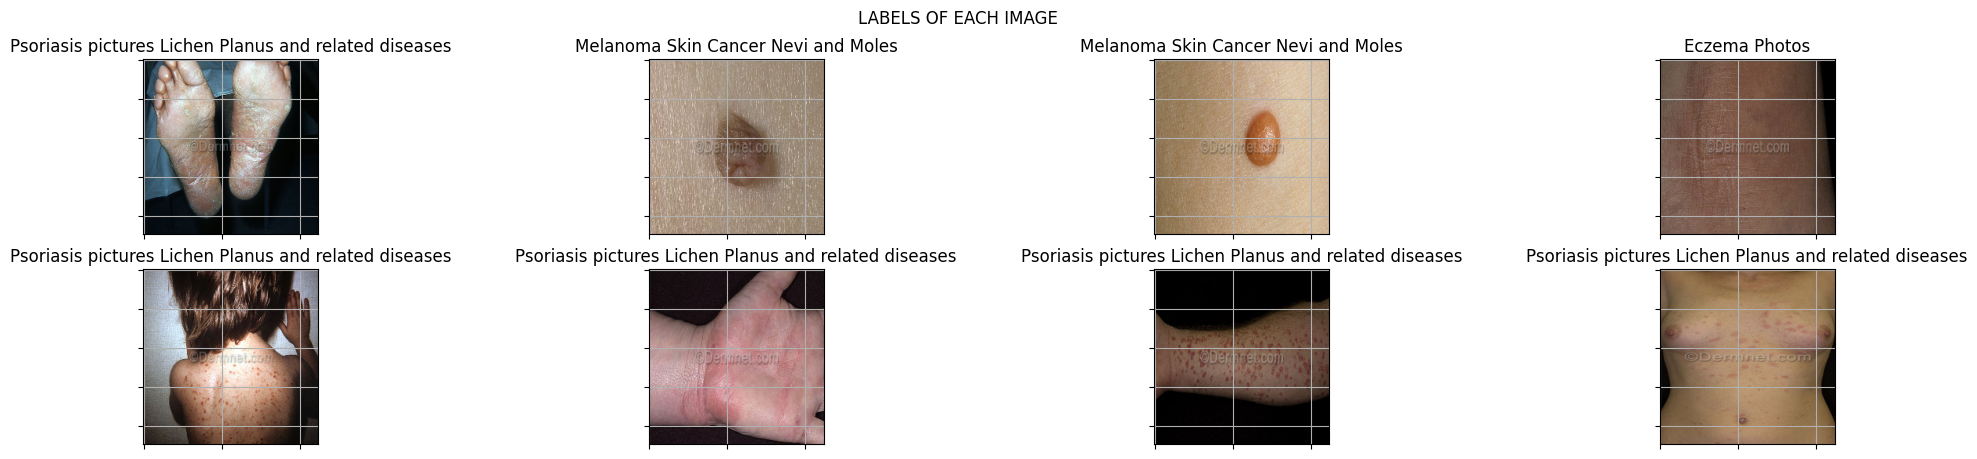

In [4]:
# Visualize some of the data
fig, axes = plt.subplots(2, 4, figsize=(25, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

In [67]:
# Extract images and labels
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

np.save('label_classes.npy', le.classes_)


In [25]:
# Initialize pre-trained models for feature extraction
num_classes = 4
image_resize = 224
input_shape = (image_resize, image_resize, 3)

In [26]:
resnet_base = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
efficientnet_base = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
resnet_base.trainable = True
efficientnet_base.trainable = True

In [40]:
input_layer = keras.Input(shape=input_shape)
resnet_output = resnet_base(input_layer)
efficientnet_output = efficientnet_base(input_layer)

resnet_gap = layers.GlobalAveragePooling2D()(resnet_output)
efficientnet_gap = layers.GlobalAveragePooling2D()(efficientnet_output)

# Concatenate the feature maps
combined_output = layers.Concatenate()([resnet_gap, efficientnet_gap])

combined_output = layers.Dropout(0.5)(combined_output)

# dense_layer = layers.Dense(256, activation='relu')(combined_output)
# dense_layer = layers.Dropout(0.5)(dense_layer)  # Another Dropout layer
feature_extractor_model = Model(inputs=input_layer, outputs=combined_output)

# Extract features for training and validation data using augmented data generator
# Use `flow` for the generator with the model for training
X_train_features = feature_extractor_model.predict(X_train)

# Extract features for validation data
X_val_features = feature_extractor_model.predict(X_val)

# Flatten features for SVM input
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_val_features = X_val_features.reshape(X_val_features.shape[0], -1)


88/88 ━━━━━━━━━━━━━━━━━━━━ 612s 7s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step


In [54]:
# Train SVM classifier on the extracted features using GridSearchCV
svm_classifier = SVC(probability=True)

# Define the parameter grid for the SVM
param_grid = {
    'kernel': ['linear', 'rbf'],  # Test linear and RBF kernels
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Used with RBF kernel
}

# Set up GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search on the training features
grid_search.fit(X_train_features, y_train_encoded)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

# Use the best estimator for predictions
best_svm_classifier = grid_search.best_estimator_

# Make predictions on the validation set using the best SVM classifier
y_val_pred = best_svm_classifier.predict(X_val_features)

# Decode the predicted labels
y_val_pred_decoded = le.inverse_transform(y_val_pred)
y_val_true_decoded = le.inverse_transform(y_val_encoded)

# Evaluate the model accuracy on the validation set
accuracy = accuracy_score(y_val_true_decoded, y_val_pred_decoded)
print(f"Validation Accuracy with SVM: {accuracy * 100:.2f}%")



Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.74
Validation Accuracy with SVM: 77.45%


In [51]:
feature_extractor_model.save('mymodel/feature_extractor_model.keras')

In [65]:
joblib.dump(best_svm_classifier, 'mymodel/svm_classifier.joblib')


['mymodel/svm_classifier.joblib']

In [66]:
for idx, disease in enumerate(le.classes_):
    print(f"Class {idx} is assigned to {disease}")

Class 0 is assigned to Eczema Photos
Class 1 is assigned to Melanoma Skin Cancer Nevi and Moles
Class 2 is assigned to Psoriasis pictures Lichen Planus and related diseases
Class 3 is assigned to Vasculitis Photos


Confusion Matrix:
 [[196   5  42   4]
 [  4  74  15   0]
 [ 36   9 230   6]
 [ 17   1  20  46]]


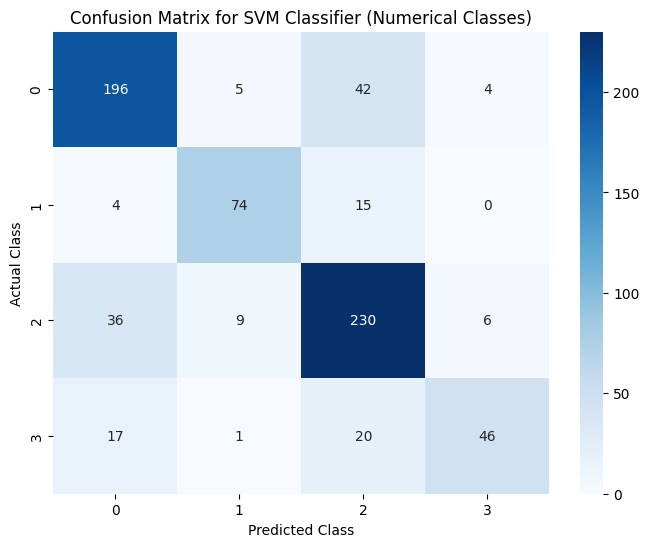

In [45]:

# Confusion Matrix to visualize classification performance
conf_matrix = confusion_matrix(y_val_true_decoded, y_val_pred_decoded)
print("Confusion Matrix:\n", conf_matrix)

# Visualize Confusion Matrix
# Plot confusion matrix with numerical classes instead of disease names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix for SVM Classifier (Numerical Classes)')
plt.show()
